We import some parts from qiskit library and other libraries.

In [46]:
from qiskit import *
from qiskit import IBMQ
from qiskit import Aer
import numpy as np
import matplotlib.pyplot as plt

from qiskit.tools.visualization import plot_bloch_multivector
from qiskit.tools.visualization import plot_histogram

we get simulators, we now have a quantum simulator, a satevector simulator and a simulator of IBM's cloud quantum machine.

In [2]:
simulator = Aer.get_backend('qasm_simulator')
statecomp = Aer.get_backend('statevector_simulator')
# IBMQ.load_account()
# provider = IBMQ.get_provider('ibm-q')
# qcomp= provider.get_backend('ibmq_qasm_simulator')

We now make our bits and basic circuit with measurement of qbit to realise it .

c:\Users\ishaa\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


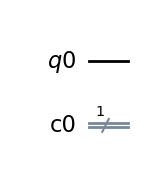

In [3]:
qbit = QuantumRegister(1,name='q0')
cbit = ClassicalRegister(1,name='c0')
qc = QuantumCircuit(qbit,cbit)
qc.draw('mpl')

We simulate our circuit with statevector simulator and present the qbit in bloch sphere.

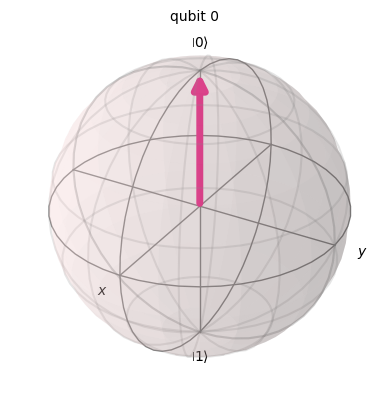

In [4]:
results = execute(qc, backend= statecomp).result()
statevector = results.get_statevector()
plot_bloch_multivector(statevector)

We rotate the qbit by $\theta$ angle along an axis say y-axis and then measure the probability of the statevector in computational basis states $ |0> $ and $|1>$ .
The rotation operator is $e^{-i\sigma_y\frac{\theta}{2}}|0⟩$ 

The probability of measuring the state $|0>$ of this qbit is : 
$$\left|⟨0|e^{-i\sigma_y\frac{\varphi}{2}}|0⟩\right|^2 = \left|⟨0|\cos\left(\frac{\varphi}{2}\right)|0⟩ + ⟨0|\sin\left(\frac{\varphi}{2}\right)|1⟩\right|^2 = \cos^2\left(\frac{\varphi}{2}\right)$$
And porbability of measuring the state $|1>$ is 
$$\left|⟨1|e^{-i\sigma_y\frac{\varphi}{2}}|0⟩\right|^2 = \left|⟨1|\cos\left(\frac{\varphi}{2}\right)|0⟩ + ⟨1|\sin\left(\frac{\varphi}{2}\right)|1⟩\right|^2 = \sin^2\left(\frac{\varphi}{2}\right)$$

We can now change $\theta$ and the difference between the angle when these probability would become their maximum would be a complete opposite rotation that is the angle $\pi$

For this we apply a rotational gate on qbit and rotate the bit intially by an angle 3.14 radian our intial guess of $\pi$. The gate is $R_Y(\theta)$ applied in qiskit using the $U(\theta, 0, 0)$ command that rorate about y-axis by $\theta$.

c:\Users\ishaa\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


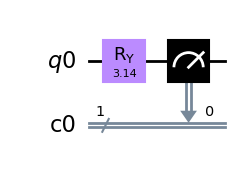

In [5]:
theta = 3.14 

qc.ry(theta,qbit)

qc.measure(qbit, cbit)
qc.draw('mpl')

This gives us the basic gate and measurement application. We apply this multiple times with different values of $\theta$ 

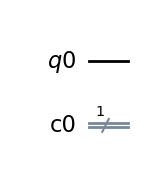

In [6]:
qc = QuantumCircuit(qbit, cbit)
qc.draw('mpl')

In [39]:
n_iter = 200
# range of pi from 3 to 4
rang = [2.8,3.4]
theta = np.linspace(rang[0], rang[1], n_iter)
# list of qtm circuits 
qc_l = []

# all circuits are same with different theta value only
for i in range(n_iter):
    qc_l.append(qc.copy())
    qc_l[i].ry(-theta[i],qbit)
    qc_l[i].measure(qbit, cbit)

We now have 100 seperate circuits with different theta angles, now we simulate these circuits : 

In [40]:
# empty counts list 
counts = []
shot = 10000
for i in range(n_iter):
    job = execute(qc_l[i], backend=simulator, shots= shot)
    counts.append(job.result().get_counts())

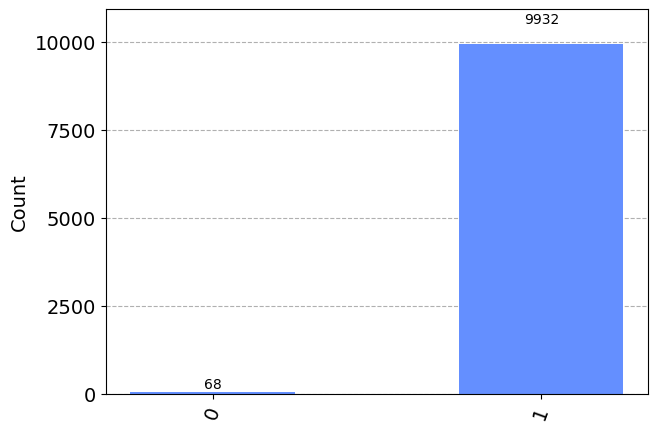

In [41]:
#Por si quieres ir viendo los histogramas, por desgracia no se pueden plotear todos juntos, pero es todo consistente.
plot_histogram(counts[-30])

Plotting this probability of measuring 1 vs the angle of rotation is : 

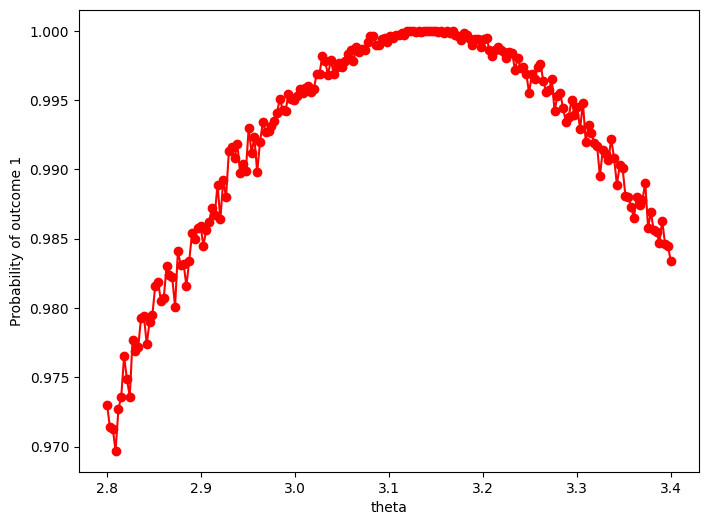

In [42]:
countsOf1 = []
for _ in counts:
    if '1' in _:
        countsOf1.append(_['1']/shot)
    else:
        countsOf1.append(0)


plt.figure(figsize=(8, 6))

plt.plot(theta, countsOf1, 'ro-')
plt.xlabel('theta'); plt.ylabel('Probability of outcome 1')

plt.show()

In [43]:
max_i = countsOf1.index(max(countsOf1))

theta_max = theta[max_i]

print('Ángulo del máximo = ', theta_max)

Ángulo del máximo =  3.1195979899497486


Making the whole thing as a single function so as to iterate it multiple times to get maximum $\theta$ for each iteration and then taking average of this $\theta$ and its standard deviation to equate it to realised value of $\pi$. 

In [48]:
def CalculatePi(simulator,shots,n,rang,plot) -> list :
    qc_l = []
    counts = []
    countsOf1 = []

    qbit = QuantumRegister(1,name='q0')
    cbit = ClassicalRegister(1,name='c0')
    qc = QuantumCircuit(qbit,cbit)
    theta = np.linspace(rang[0],rang[1],n)
    
    for i in range(n):
        qc_l.append(qc.copy())
        qc_l[i].ry(-theta[i],qbit)
        qc_l[i].measure(qbit, cbit)
    
    for i in range(n):
        job = execute(qc_l[i], backend=simulator, shots= shots)
        counts.append(job.result().get_counts())
    
    for _ in counts:
        if '1' in _:
            countsOf1.append(_['1']/shot)
        else:
            countsOf1.append(0)
    
    max_i = countsOf1.index(max(countsOf1))
    theta_max = theta[max_i]

    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(theta, countsOf1, 'ro-'); plt.xlabel('theta'); plt.ylabel('Probabilidad')
        plt.tight_layout; plt.show()
        print('maximum angle  ', theta_max)
    
    return theta, countsOf1, theta_max

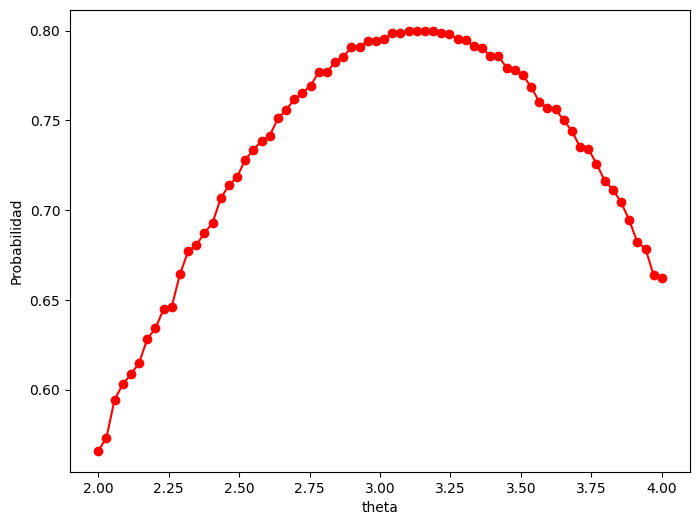

maximum angle   3.1304347826086953


In [51]:
theta, countsOf1, theta_max = CalculatePi(simulator, shots = 8000, n=70, rang = [2,4],plot = 1)